# 2. Simple Accuracy Test

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as ag
import time
import h5py

import sys
sys.path.append('../utilities/')
from pytorch_complex import *
from utility import *

sys.path.append('../models/')
from mri import *
from pytorch_proximal import *
from pytorch_transforms import *

sys.path.append('../meld/')
from meld import *


import sigpy.plot as pl

dtype = torch.float32
np_dtype = np.float32

mul_c  = ComplexMul().apply
div_c  = ComplexDiv().apply
abs_c = ComplexAbs().apply

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# setup GPU
gpu_device = 0
torch.cuda.set_device(gpu_device)
device = torch.device("cuda:"+str(gpu_device) if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_properties(gpu_device)

_CudaDeviceProperties(name='TITAN Xp', major=6, minor=1, total_memory=12196MB, multi_processor_count=30)

## Load data

In [13]:
data_idx = 1
with h5py.File('/mikRAID/dataset_train_full.h5', 'r') as f:
    imgs = np.array(f['imgs'][data_idx,...])
    maps = np.array(f['maps'][data_idx,...])
    masks = np.array(f['masks'][data_idx,...])
    

print(imgs.shape, maps.shape, masks.shape)

(256, 232) (12, 256, 232) (256, 232)


## Transform into torch variables

In [5]:
imgs_t = torch.stack((torch.from_numpy(imgs.real),torch.from_numpy(imgs.imag)),2)
maps_t = torch.stack((torch.from_numpy(maps.real),torch.from_numpy(maps.imag)),3)

# under sampling
# masks_t = torch.stack((torch.from_numpy(masks),torch.from_numpy(masks)),2)

# fully sampled
masks_t = torch.ones_like(imgs_t)

Np = imgs_t.shape[0:2]
print(imgs_t.shape, maps_t.shape, masks_t.shape)
print(Np)

torch.Size([256, 232, 2]) torch.Size([12, 256, 232, 2]) torch.Size([256, 232, 2])
torch.Size([256, 232])


## Setup Model

In [16]:
from mri import *
alpha = torch.tensor([1e-1]).type(dtype)
grad = MRI(Np,imgs_t.to(device),maps_t.to(device),masks_t.to(device),alpha,noise_level=0.,device=device)
grad.to(device)

MRI()

## Verify: Forward Backward Accuracy Check

In [21]:
from mri import *
x = torch.randn_like(imgs_t).to(device)
output = grad.forward(x,device=device)

In [22]:
print(output.shape)

torch.Size([256, 232, 2])


# Done upto here.

<IPython.core.display.Javascript object>


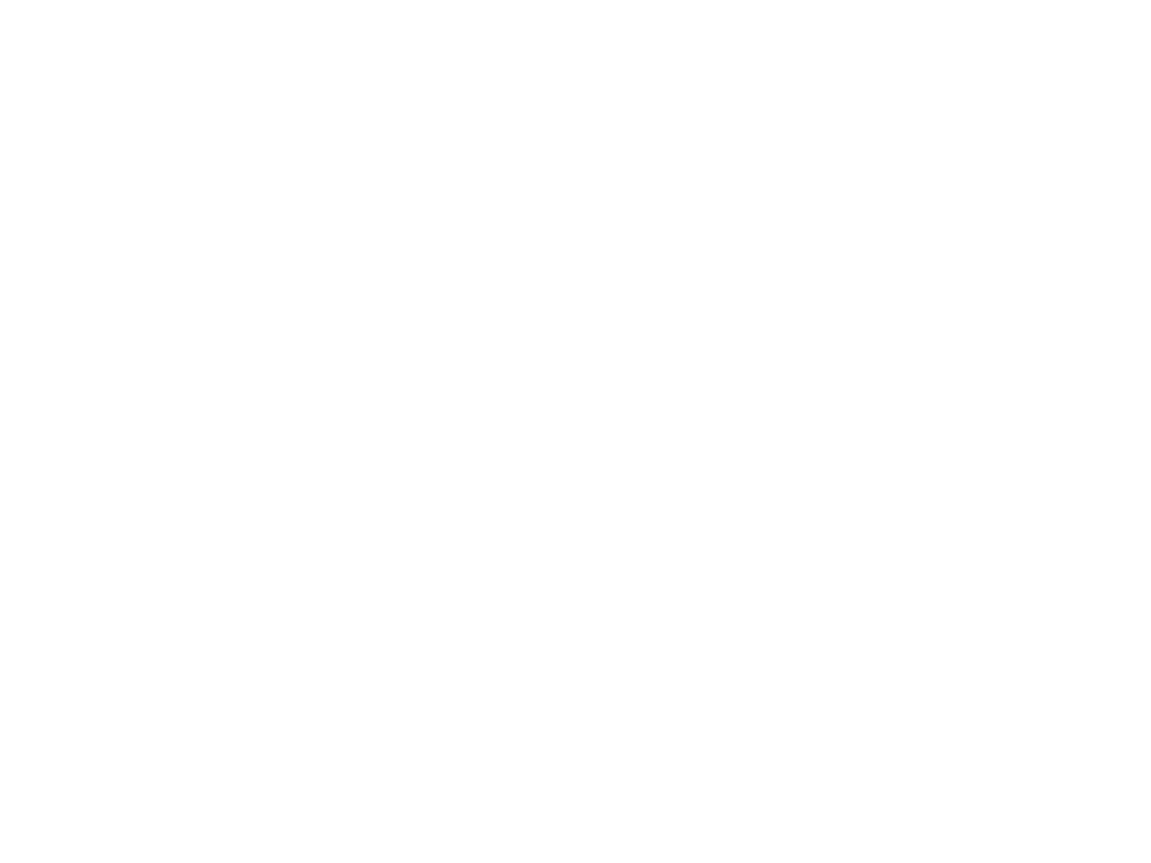

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [23]:
coil_idx = 4
plt.figure()
plt.imshow(getAbs(torch.ifft(grad.y[coil_idx,...],2)).numpy())

In [114]:
# test gradient
output = grad.grad(torch.zeros_like(imgs_t))
# output = grad.grad(imgs_t)
print(output.shape)

torch.Size([256, 232, 2])


<IPython.core.display.Javascript object>


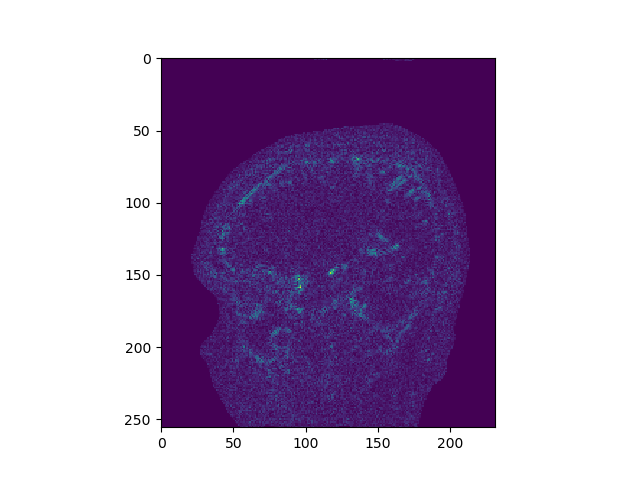

In [115]:
M = torch.sum(getAbs(maps_t),dim=0).numpy()

plt.figure()
plt.imshow(getAbs(output).numpy())

<IPython.core.display.Javascript object>


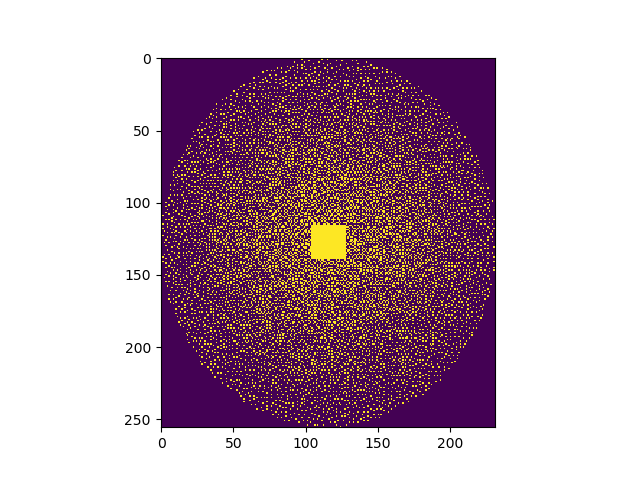

In [113]:
plt.figure()
plt.imshow(masks)

## Setup iterative reconstruction network

In [134]:
testFlag = True

from mri import *
alpha = torch.tensor([1e-1],device=device).type(dtype)
grad = MRI(Np,imgs_t.to(device),maps_t.to(device),masks_t.to(device),alpha,noise_level=0,device=device,testFlag=testFlag)
grad.to(device)

# setup proximal model
from pytorch_proximal import *
thr = torch.tensor([1e-2],device=device).type(dtype)
alpha = torch.tensor([1e-4],device=device).type(dtype)
prox = AbsWaveletSoftThr(Np,thr,alpha,testFlag=testFlag,device=device)
prox.to(device)

pgd = PGD(grad,prox)
N = 100
network = genNetwork(pgd,N)


[autoreload of pytorch_proximal failed: Traceback (most recent call last):
  File "/home/kellman/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/kellman/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/home/kellman/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/kellman/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../../Denoiser

NameError: name 'AbsWaveletSoftThr' is not defined

In [129]:
x0 = torch.zeros_like(imgs_t).to(device)
xN,X = feedforward(network,x0,interFlag=True,testFlag=True,device=device)

RuntimeError: expand(torch.cuda.FloatTensor{[128, 116, 2]}, size=[128, 116]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)